In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, 
    Dropout, Flatten, GlobalMaxPooling2D, MaxPooling2D
)   
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from load_data import unpickle

In [2]:
train_data = unpickle('data/data_batch_1')
validation_data = unpickle('data/data_batch_2')
test_data = unpickle('data/data_batch_3')

In [3]:
X_train, y_train = train_data[b'data'], np.array(train_data[b'labels'])
X_train, y_train = X_train.reshape(10000, 32, 32, 3) / 255, to_categorical(y_train)

X_validation, y_validation = validation_data[b'data'], np.array(validation_data[b'labels'])    
X_validation, y_validation = X_validation.reshape(10000, 32, 32, 3) / 255, to_categorical(y_validation)

X_test, y_test = test_data[b'data'], np.array(test_data[b'labels'])    
X_test, y_test = X_test.reshape(10000, 32, 32, 3) / 255, to_categorical(y_test)

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model.add(GlobalMaxPooling2D())
model.add(Dense(10, activation='softmax'))

In [7]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='Nadam', 
    metrics=['categorical_accuracy']
)

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 20,042
Trainable params: 20,042
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=100, 
    validation_data=(X_validation, y_validation)
)

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.7262 - categorical_accuracy: 0.3944 - val_loss: 2.0072 - val_categorical_accuracy: 0.2880
Epoch 2/100
10000/10000 [==============================] - 15s 2ms/sample - loss: 1.7099 - categorical_accuracy: 0.4037 - val_loss: 1.8907 - val_categorical_accuracy: 0.3333
Epoch 3/100
10000/10000 [==============================] - 15s 1ms/sample - loss: 1.6959 - categorical_accuracy: 0.4090 - val_loss: 1.9057 - val_categorical_accuracy: 0.3248
Epoch 4/100
10000/10000 [==============================] - 15s 1ms/sample - loss: 1.6823 - categorical_accuracy: 0.4163 - val_loss: 1.9786 - val_categorical_accuracy: 0.2991
Epoch 5/100
10000/10000 [==============================] - 15s 1ms/sample - loss: 1.6719 - categorical_accuracy: 0.4195 - val_loss: 1.8595 - val_categorical_accuracy: 0.3563
Epoch 6/100
10000/10000 [==============================] - 15s 2ms/sample - loss

10000/10000 [==============================] - 13s 1ms/sample - loss: 1.4100 - categorical_accuracy: 0.5197 - val_loss: 1.7928 - val_categorical_accuracy: 0.3870
Epoch 48/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.4036 - categorical_accuracy: 0.5198 - val_loss: 1.8364 - val_categorical_accuracy: 0.3878
Epoch 49/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.3985 - categorical_accuracy: 0.5244 - val_loss: 1.7881 - val_categorical_accuracy: 0.3919
Epoch 50/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.3934 - categorical_accuracy: 0.5258 - val_loss: 1.8844 - val_categorical_accuracy: 0.3750
Epoch 51/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.3923 - categorical_accuracy: 0.5238 - val_loss: 1.9000 - val_categorical_accuracy: 0.3577
Epoch 52/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.3883 - categorical_accuracy: 0.5277 - val_loss: 1.762

Epoch 94/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2651 - categorical_accuracy: 0.5677 - val_loss: 1.8470 - val_categorical_accuracy: 0.3909
Epoch 95/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2597 - categorical_accuracy: 0.5727 - val_loss: 1.8685 - val_categorical_accuracy: 0.3915
Epoch 96/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2579 - categorical_accuracy: 0.5737 - val_loss: 1.8420 - val_categorical_accuracy: 0.3975
Epoch 97/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2571 - categorical_accuracy: 0.5685 - val_loss: 1.8429 - val_categorical_accuracy: 0.3976
Epoch 98/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2549 - categorical_accuracy: 0.5686 - val_loss: 1.8350 - val_categorical_accuracy: 0.3989
Epoch 99/100
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.2515 - categorical_accuracy: 0.5742 - va

In [14]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 214us/sample - loss: 1.8195 - categorical_accuracy: 0.4051

Test result: 40.510 loss: 1.820


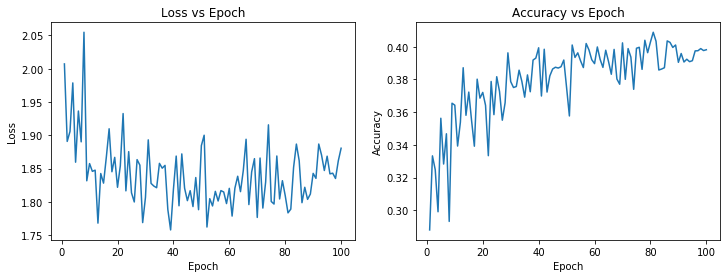

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.flatten()

loss = sns.lineplot(
    x=np.arange(1, 101), 
    y=history.history['val_loss'], 
    ax=axes[0]
)
loss.set(title="Loss vs Epoch", xlabel="Epoch", ylabel="Loss")

accuracy = sns.lineplot(
    x=np.arange(1, 101), 
    y=history.history['val_categorical_accuracy'], 
    ax=axes[1]
)
accuracy.set(title="Accuracy vs Epoch", xlabel="Epoch", ylabel="Accuracy")
plt.show()